# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Importing necessary libraries

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
from random import randint
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

### Read the Data

In [114]:
data = "data_for_student_case.csv" #modify the path here for wherever the data is.
df1 = pd.read_csv(data)

### A look at the data

In [115]:
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Data Preprocessing

In [116]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    #3-6 is just 3 for cvcresponsecode.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc1 = LabelEncoder()
    enc1.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df1['currencycode'])
    df1['currencycode'] = enc2.transform(df1.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

    enc4 = LabelEncoder()
    enc4.fit(df1['accountcode'])
    df1['accountcode'] = enc4.transform(df1.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)
    
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['date'] = df1['creationdate'].dt.date
        
    enc6 = LabelEncoder()
    enc6.fit(df1['mail_id'])
    df1['mail_id'] = enc6.transform(df1.mail_id)

    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    df1['day_of_week'] = df1['creationdate'].dt.dayofweek

    df1['hour'] = df1['creationdate'].dt.hour
    
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    df1 = df1.loc[~((df1['simple_journal'] == 0)&(df1['amount_eur']>320))]
    return df1

In [117]:
def smote(n,k,df,y):

    df1=df.copy(deep=True)
    
    df1["simple_journal"]=y
    
    df_fraud= df1.loc[df1["simple_journal"]==1]
    
    df_notfraud = df1.loc[df1["simple_journal"]==0]
    
    df_fraudmat = df_fraud.values

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(df_fraudmat)
    distances, indices = nbrs.kneighbors(df_fraudmat)

    synthetic=[]
    
    T = len(df_fraudmat)
    N = n
    
    for i in range(T):
        value = random.sample(range(1, k), N)
        for j in value:
            ind = indices[i][j]
            diff= df_fraudmat[ind]-df_fraudmat[i]
            synthetic.append((df_fraudmat[i]+(random.uniform(0, 1))*diff))#.astype(int))

    
    synthetic=pd.DataFrame(synthetic,columns=df_fraud.columns)
    
    
    DF_syn_nf = pd.concat([synthetic, df_notfraud],sort=False)
    
    df_syn_nf_mat = DF_syn_nf.values
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(df_syn_nf_mat)
    distances, indices = nbrs.kneighbors(df_syn_nf_mat[:len(synthetic)])
    
    notneeded=[]
    for i in indices:
        if i[1]>len(synthetic):
            notneeded.append(i[0])
    needed = list(set(np.arange(len(synthetic))) - set(notneeded))
    needed_df = pd.DataFrame([synthetic.iloc[i] for i in needed])
    
    DF_Fraud = pd.concat([needed_df,df_fraud],sort=False)
    
    
    return  pd.concat([DF_Fraud, df_notfraud],sort=False)

In [118]:
df = preprocess(df1)

In [119]:
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,accountcode,mail_id,ip_id,card_id,date,countries_equal,day_of_week,hour,creationdate_Unix,amount_eur
0,1,2015-11-09 14:26:51,104,2,1998,64800.0,2,104,1,1,...,1,187702,7386,73358,2015-07-01,1,2,23,1435791791,30.446979
1,2,2015-11-09 14:27:38,104,2,2364,44900.0,2,104,1,1,...,1,834,194109,44739,2015-07-02,1,3,4,1435812655,21.096749
2,3,2015-11-23 16:34:16,104,2,1965,149900.0,2,104,1,1,...,1,119287,189655,122802,2015-07-02,1,3,14,1435847428,70.432131
3,4,2015-11-23 16:34:51,104,2,2374,109900.0,2,104,1,1,...,1,173561,8254,70712,2015-07-03,1,4,7,1435910017,51.637700
4,5,2015-11-09 14:26:08,104,6,1301,89900.0,2,104,1,1,...,1,70647,196247,208481,2015-07-08,1,2,18,1436380535,42.240484


In [134]:
df2= df.drop(columns=['txid','creationdate','bookingdate','amount','date','shopperinteraction','cardverificationcodesupplied','mail_id','creationdate_Unix','card_id','countries_equal','day_of_week','currencycode'])

In [135]:
X = df2.drop(columns="simple_journal")
y = df2["simple_journal"]

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.20)

In [159]:
X_train.shape,y_train.sum()

((188402, 9), 276)

In [160]:
df_smote=smote(5,6,X_train,y_train)

In [161]:
X_train = df_smote.drop(columns="simple_journal")
y_train = df_smote["simple_journal"]

In [162]:
X_train.shape,y_train.sum()
s=int(y_train.sum())

In [163]:
#subsampling keeping 10% fraud and 90% non fraud cases
posindex=[]
for i in enumerate(y_train):
    if i[1]==1:
        posindex.append(i[0])
fullindex=list(range(0,len(y_train)))
sampleindex= list(set(fullindex)-set(posindex))
randomlist = list(set(random.sample(range(0, len(sampleindex)),int(s*10-s))))
randomlist = list(np.array(sampleindex)[randomlist])
randomlist.extend(posindex)
random.shuffle(randomlist)
X_train=(X_train.iloc[randomlist])
y_train=np.array(y_train)
y_train=y_train[randomlist].ravel()
posindex=[]

In [164]:
scaler =StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [165]:
#from sklearn import decomposition
#pca = decomposition.PCA(n_components=3)
#pca.fit(X_train)
#X_train =pca.transform(X_train)
#pca.fit(X_test)
#X_test = pca.transform(X_test)

In [169]:
X_train.shape,y_train.sum(),X_test.shape,y_test.sum()

((10760, 9), 1076.0, (47101, 9), 69)

Number of mislabeled points out of a total 47101 points : 9346
accuracy:  0.801575338103225


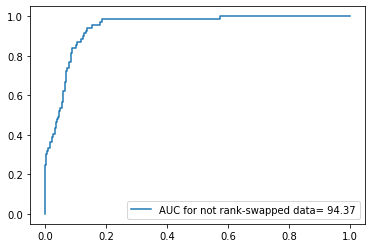

(37687, 9345, 1, 68)

In [170]:
clf = LogisticRegression(penalty="elasticnet",class_weight="balanced",max_iter=100,solver="saga",l1_ratio=0.9,C=.1)


y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC for not rank-swapped data= " +str(round(auc*100,2)))

plt.legend(loc=4)
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
(tn, fp, fn, tp)


Number of mislabeled points out of a total 47101 points : 4406
accuracy:  0.9064563385066134


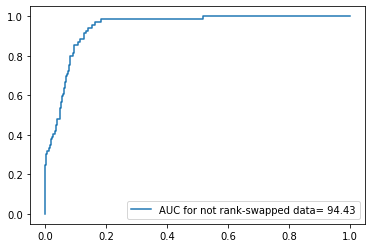

(42639, 4393, 13, 56)

In [171]:
clf = LogisticRegression(penalty="elasticnet",max_iter=100,solver="saga",l1_ratio=0.9,C=.1)


y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC for not rank-swapped data= " +str(round(auc*100,2)))

plt.legend(loc=4)
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
(tn, fp, fn, tp)